In [52]:
import numpy as np

from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from scipy.io import loadmat
from ImageProcessing import *

import matplotlib.pyplot as plt
import matplotlib.scale as scale

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

# Loading Data

In [53]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

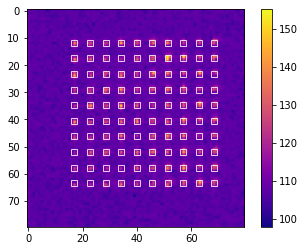

In [54]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

(array([5.71426942, 0.        ]),
 array([0.        , 5.74297133]),
 array([17.03288858, 11.77351072]))

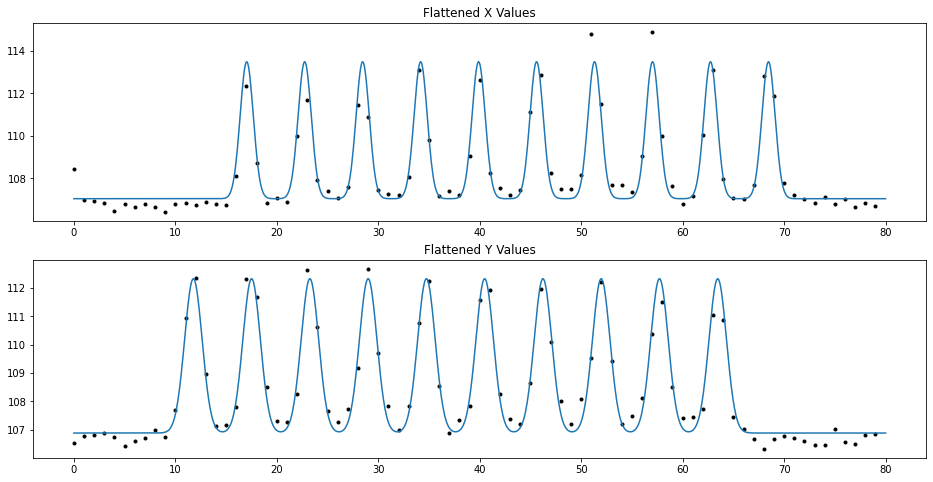

In [55]:
processor.lattice_characteristics_rect(plot=True)

(272000, 6, 6)


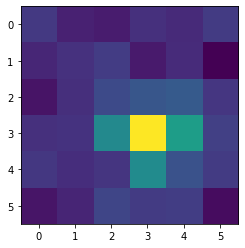

In [56]:
crops = processor.crop_sites(1)
print(crops.shape)
plt.imshow(np.mean(crops[processor.crop_index(0, 0, 0): processor.crop_index(1, 0, 0)], axis=0))

# Creating Labels with Thresholding Algorithm

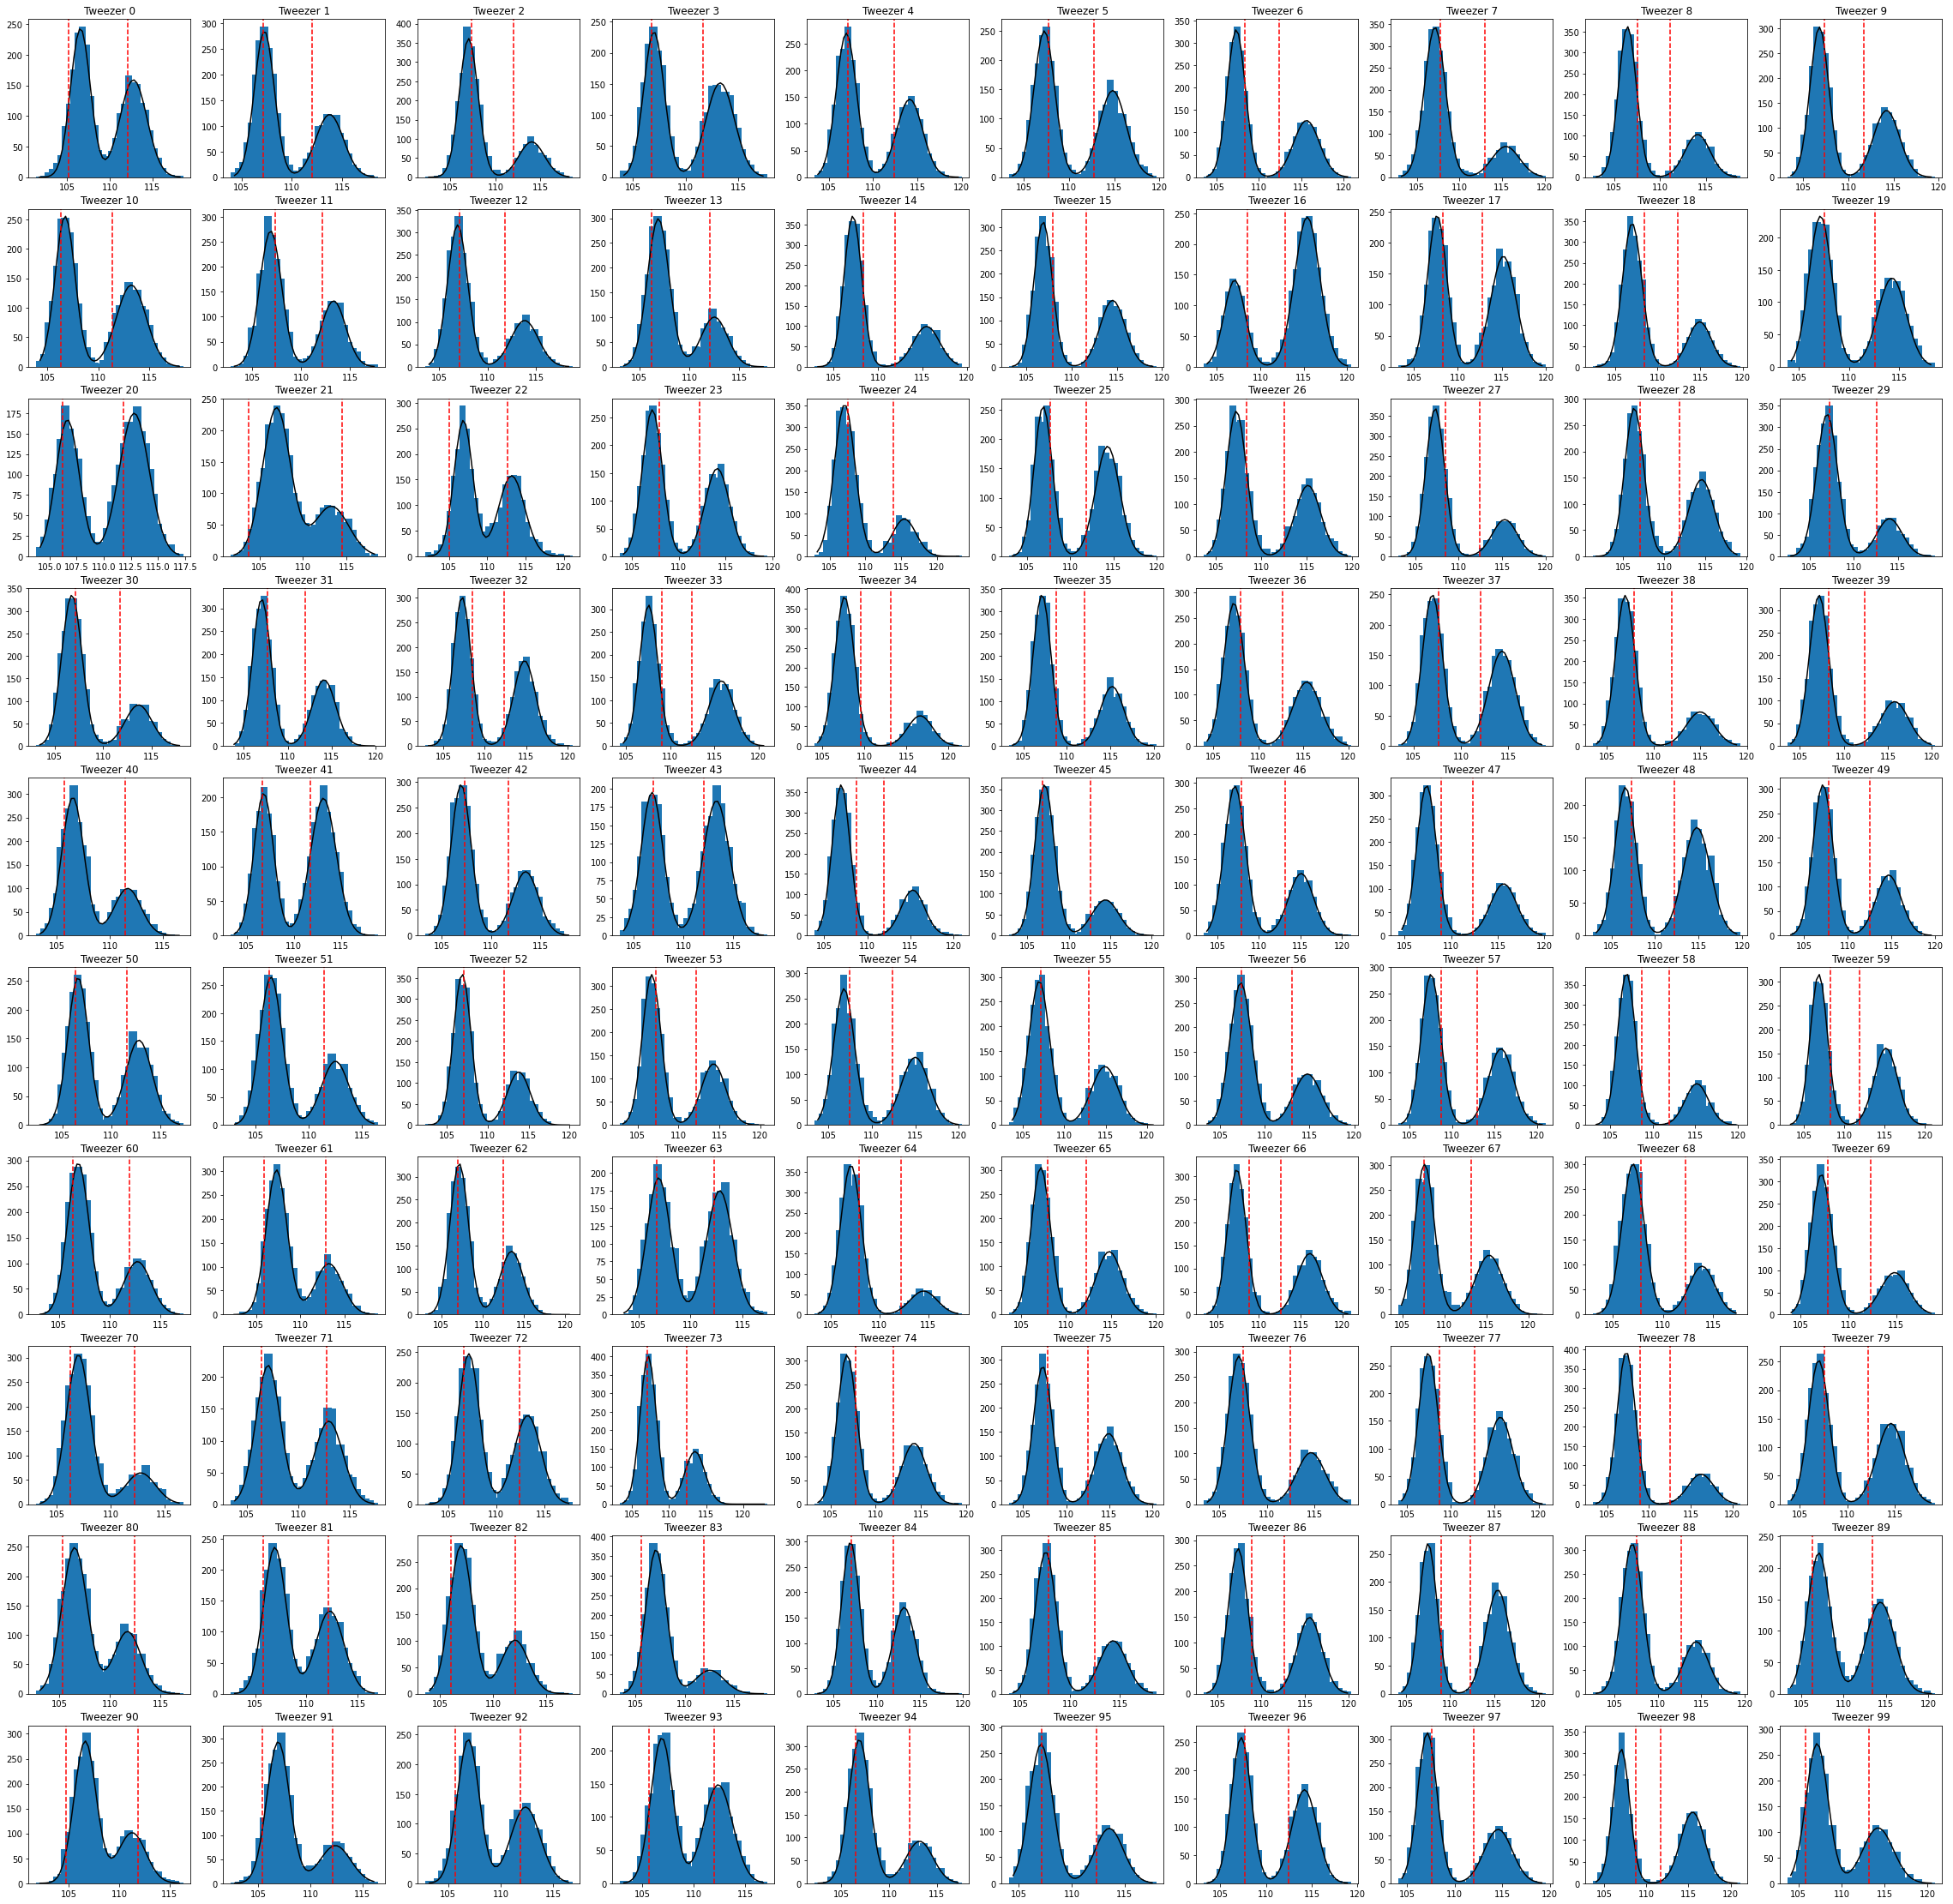

In [57]:
crops, labels = processor.make_dataset(1, keep_unknowns=True, plot=True)

In [60]:
labels, thresholds = processor.make_labels()

42


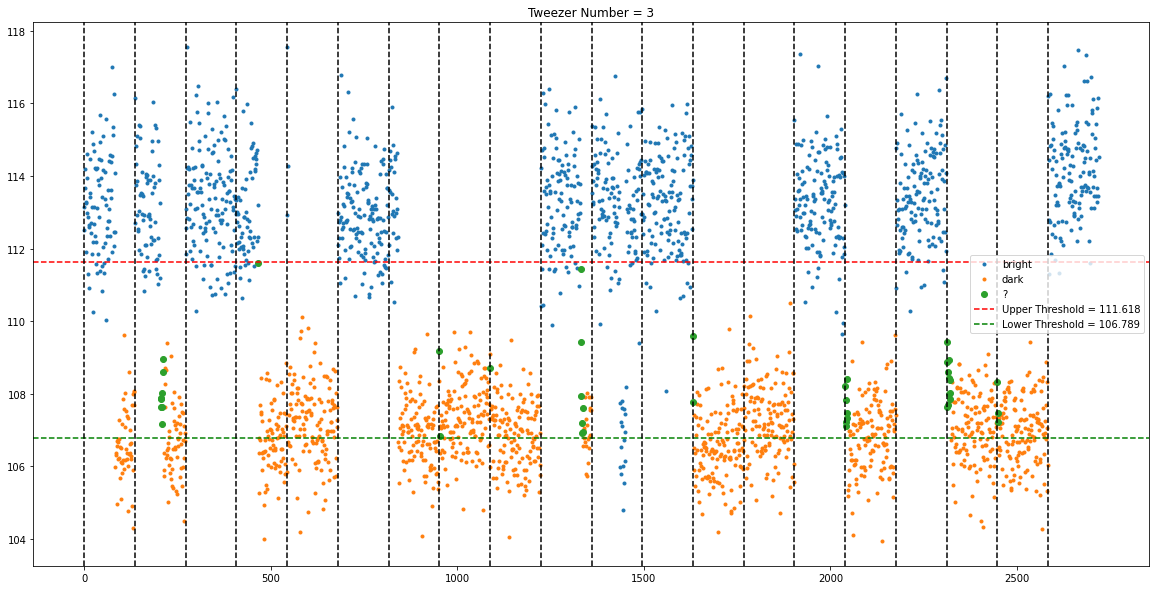

In [61]:
tweezer = 3

tweezer_vals = np.mean(crops[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)], axis=(1, 2))
tweezer_labels = labels[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)]

bright_mask = tweezer_labels[:, 1] == 1
dark_mask = tweezer_labels[:, 0] == 1
unknown_mask = np.isnan(tweezer_labels[:, 0])

bright_indices = np.where(bright_mask)[0]
bright_vals = tweezer_vals[bright_mask]

dark_indices = np.where(dark_mask)[0]
dark_vals = tweezer_vals[dark_mask]

unknown_indices = np.where(unknown_mask)[0]
unknown_vals = tweezer_vals[unknown_mask]

print(len(unknown_vals))
plt.figure(figsize=(20, 10))
plt.plot(bright_indices, bright_vals, '.', label='bright')
plt.plot(dark_indices, dark_vals, '.', label='dark')
plt.plot(unknown_indices, unknown_vals, 'o', label='?')
plt.axhline(thresholds[tweezer, 1], color='r', linestyle='--', label=f"Upper Threshold = {thresholds[tweezer, 1]:.3f}")
plt.axhline(thresholds[tweezer, 0], color='g', linestyle='--', label=f"Lower Threshold = {thresholds[tweezer, 0]:.3f}")
plt.legend()
plt.title(f"Tweezer Number = {tweezer}")
for i in range(n_loops):
    plt.axvline(i * processor.per_loop, color='k', linestyle='--', label="Loop Separation")
plt.show()

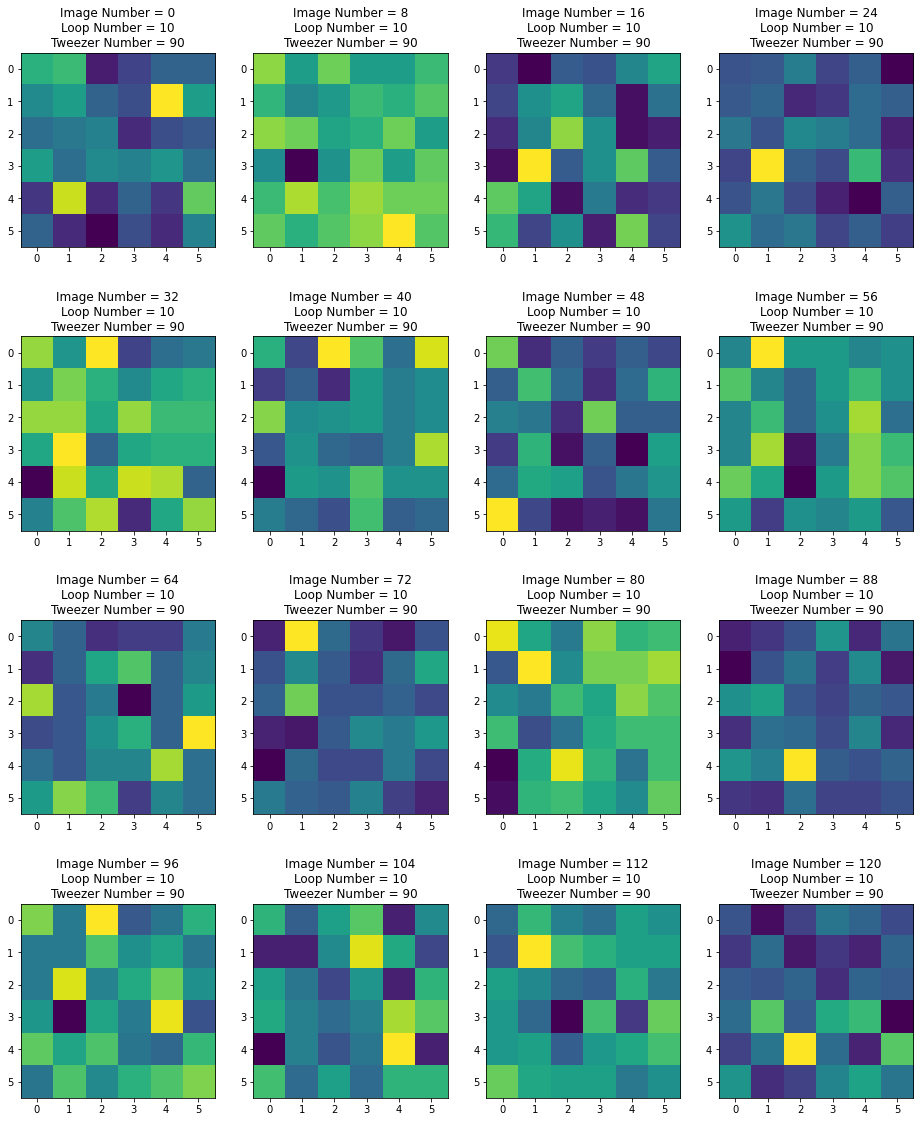

In [9]:
#i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop - 4)
loop = 10

fig, axs = plt.subplots(4, 4, figsize=(16, 20))

for n in range(16):
    axs[n // 4, np.mod(n, 4)].imshow(crops[processor.crop_index(tweezer, loop, 8 * n)])
    axs[n // 4, np.mod(n, 4)].set_title(f"Image Number = {8 * n}\nLoop Number = {loop}\nTweezer Number = {tweezer}")

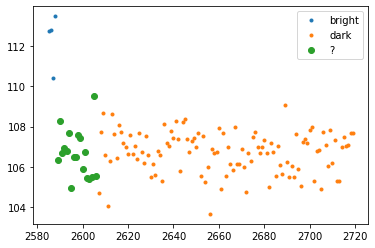

In [10]:
loop_num = 19
low = processor.per_loop * loop_num
high = processor.per_loop * (loop_num + 1)
bright_mask = (low < bright_indices) & (bright_indices < high)
dark_mask = (low < dark_indices) & (dark_indices < high)
unknown_mask = (low < unknown_indices) & (unknown_indices < high)

plt.plot(bright_indices[bright_mask], bright_vals[bright_mask], '.', label='bright')
plt.plot(dark_indices[dark_mask], dark_vals[dark_mask], '.', label='dark')
plt.plot(unknown_indices[unknown_mask], unknown_vals[unknown_mask], 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--')
#plt.axhline(lower_threshold, color='r', linestyle='--')
plt.legend()
plt.show()

# Making Training and Testing Datasets

In [11]:
data = loadmat('camera,fIdx=3350625,imagingDetuning0_MHz=-0.600000000,gateSequenceScanValue2=0,nuvuCamExposureTime=0.000021000,gateSequenceScanValue=0.000001000,iterator=21.000000000')
n_loops = 20
lattice_shape = np.array([10, 10])
test_stack = data['stack']

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


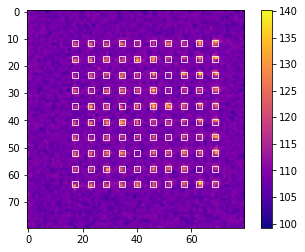

In [12]:
testing_processor = GreenImageProcessor(test_stack, np.array([10, 10]), 20)
testing_processor.plot()

In [13]:
crops = testing_processor.crop_sites(1)

(array([  2.,   7.,  20.,  70., 161., 244., 305., 293., 200., 117.,  43.,
         24.,  17.,  29.,  16.,  41.,  41.,  43.,  46.,  30.,  23.,  16.,
          6.,   4.,   2.]),
 array([104.5       , 105.09111111, 105.68222222, 106.27333333,
        106.86444444, 107.45555556, 108.04666667, 108.63777778,
        109.22888889, 109.82      , 110.41111111, 111.00222222,
        111.59333333, 112.18444444, 112.77555556, 113.36666667,
        113.95777778, 114.54888889, 115.14      , 115.73111111,
        116.32222222, 116.91333333, 117.50444444, 118.09555556,
        118.68666667, 119.27777778]),
 <BarContainer object of 25 artists>)

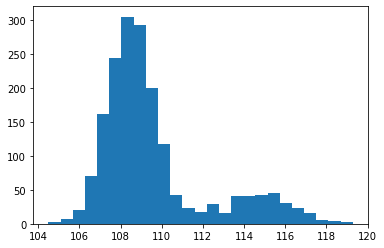

In [14]:
plt.hist(np.mean(crops[testing_processor.crop_index(5, 0, 0): testing_processor.crop_index(6, 0, 0)], axis=(1, 2)), bins=25)

/Users/jackmango/Desktop/QUIRP - Work/Princeton/ImagingSoftware/AutoGauss.py:75: RuntimeWarning: invalid value encountered in true_divide
  return a * np.exp(- (x - mean) ** 2 / (2 * std ** 2))
/Users/jackmango/Desktop/QUIRP - Work/Princeton/ImagingSoftware/ImageProcessing.py:261: RuntimeWarning: invalid value encountered in double_scalars
  lower_thresh = bright_fit[0] - bright_fit[1] * z


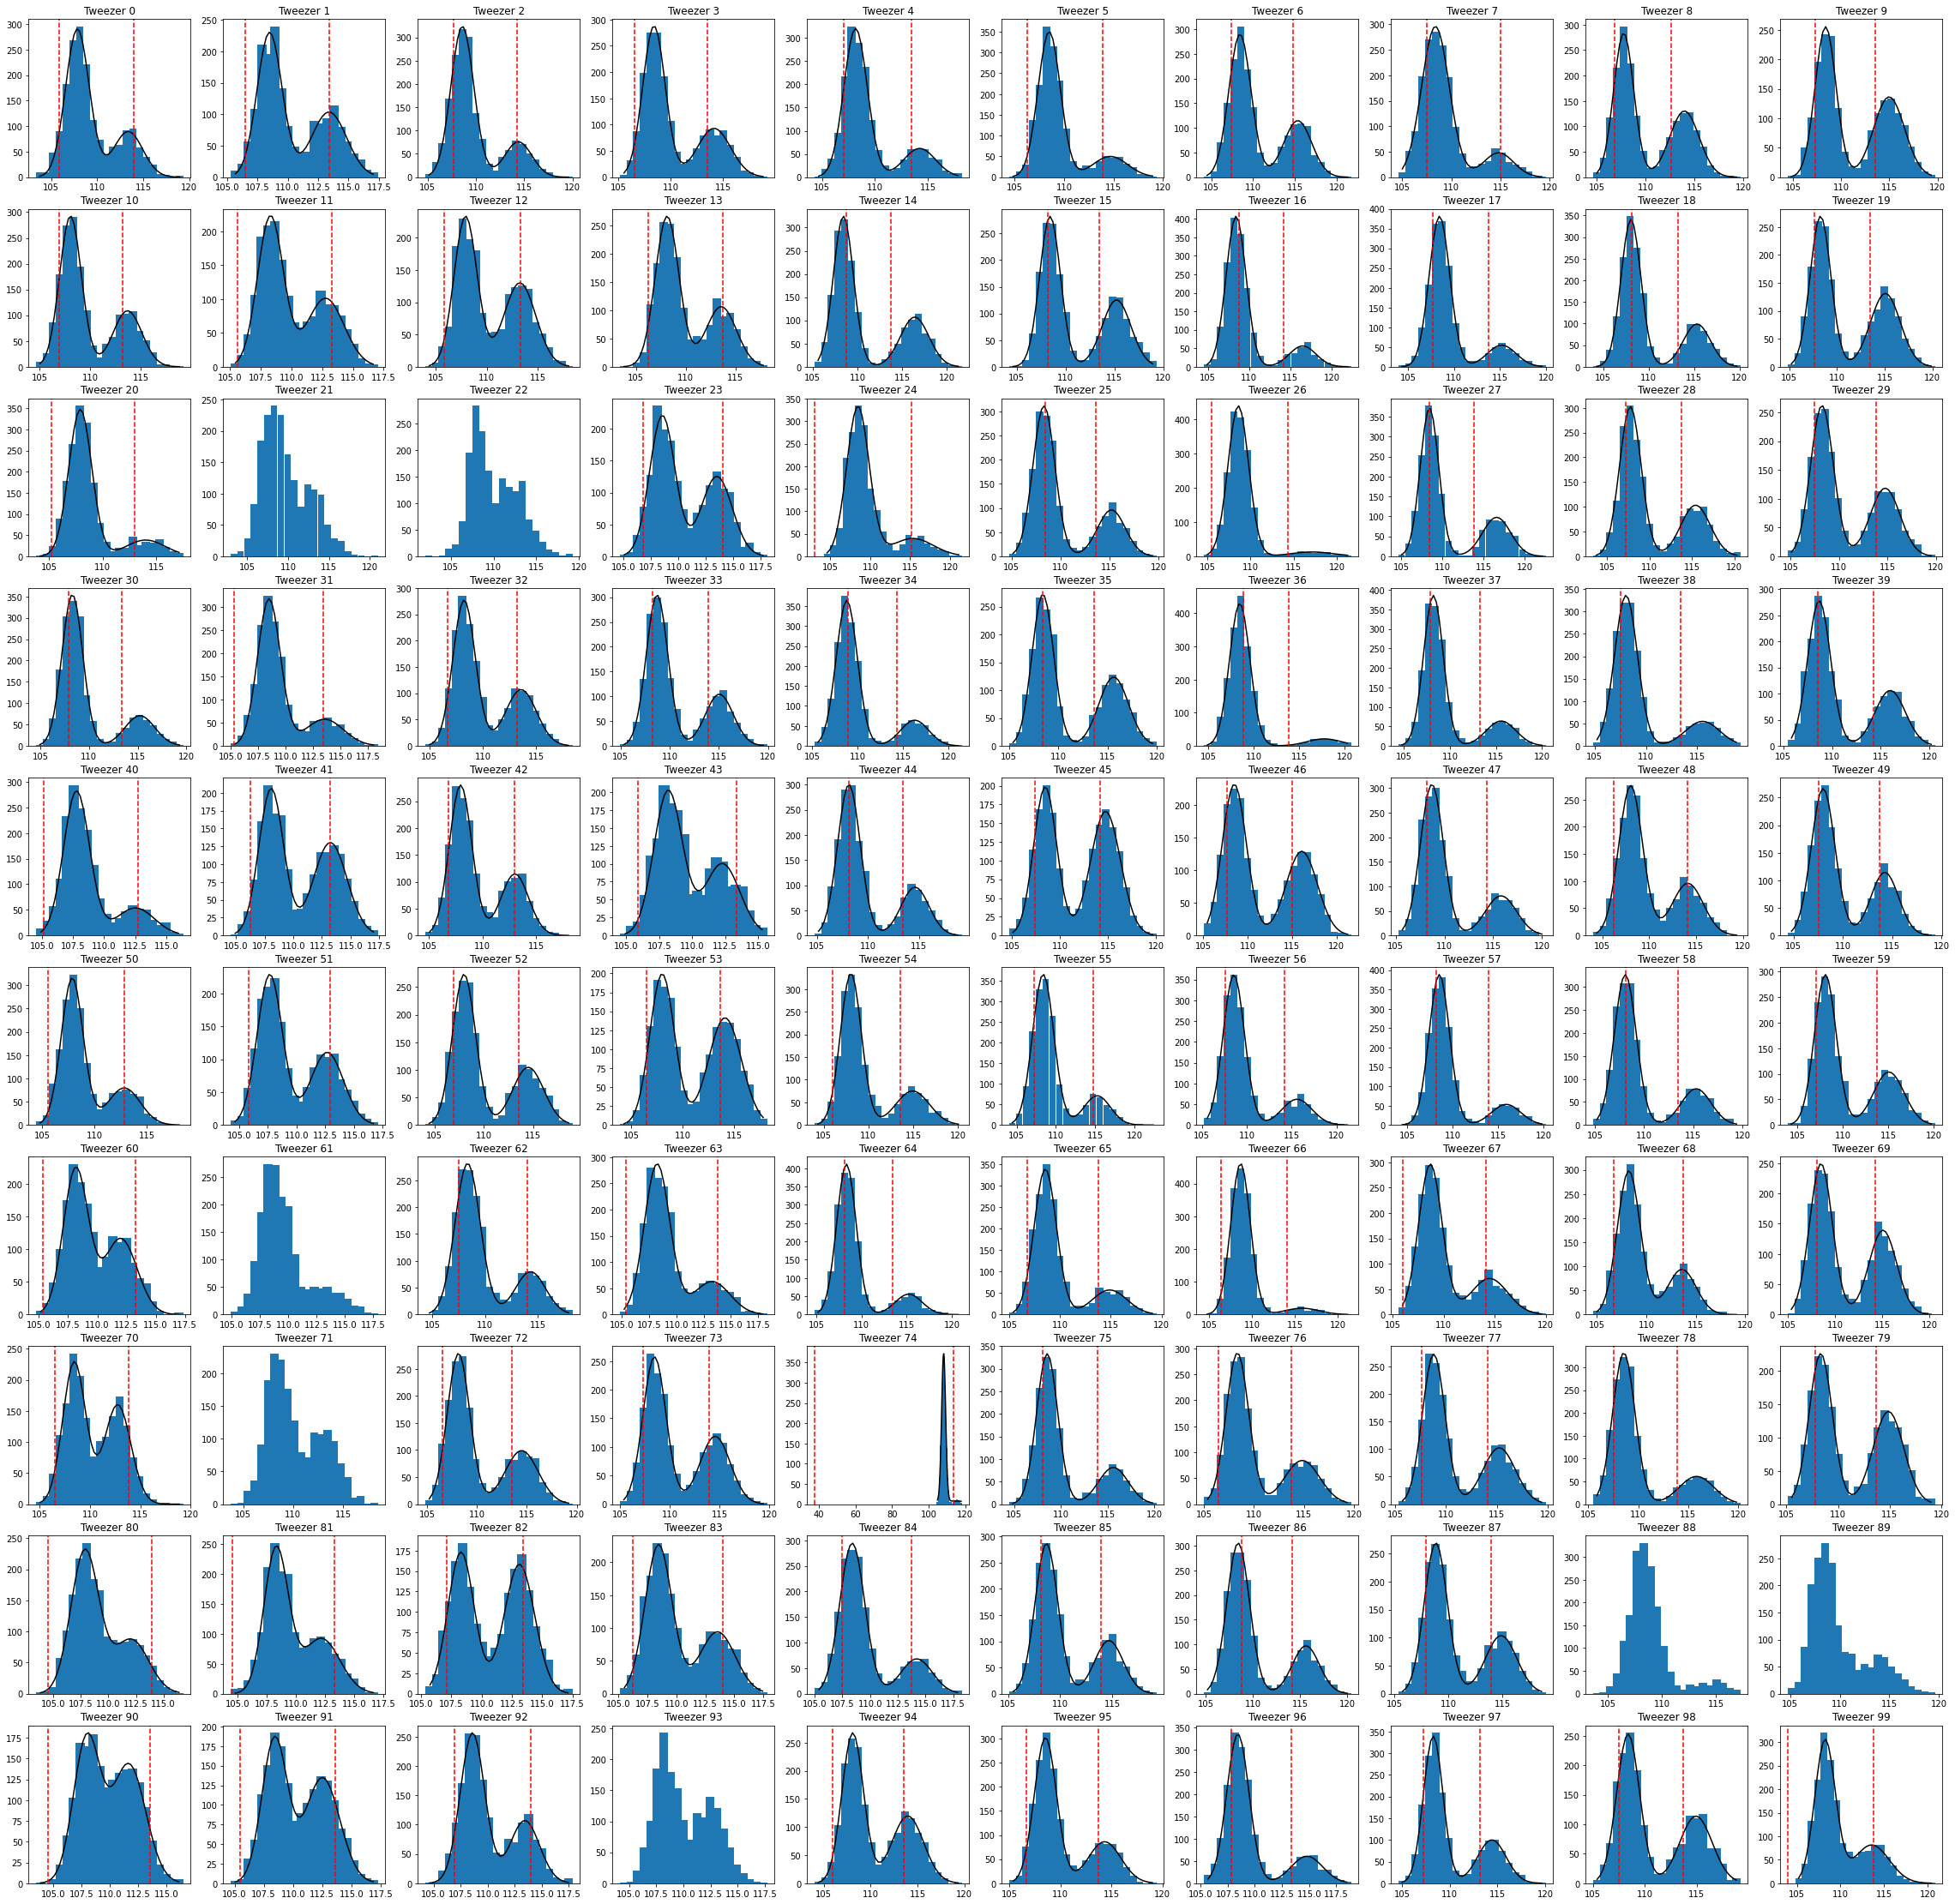

In [15]:
training_images, training_labels = processor.make_dataset()
testing_images, testing_labels = testing_processor.make_dataset(plot=True)

(267044, 2) (267044, 18, 18)


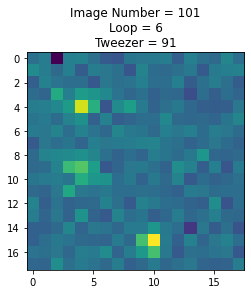

In [26]:
i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop)
plt.imshow(training_images[processor.crop_index(i, j, k)])
plt.title(f"Image Number = {k}\nLoop = {j}\nTweezer = {i}")
plt.plot()
print(training_labels.shape, training_images.shape)

# Neural Network Models

In [17]:
networks = [models.Sequential() for i in range(4)]

In [18]:
networks[0] = models.Sequential()
networks[0].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[0].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[0].add(layers.Flatten())
networks[0].add(layers.Dense(2, activation='sigmoid'))

networks[0].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [19]:
networks[1] = models.Sequential()
networks[1].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Flatten())
networks[1].add(layers.Dense(2, activation='sigmoid'))

networks[1].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3138      
                                                                 
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________


In [20]:
networks[2] = models.Sequential()
networks[2].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[2].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[2].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.Flatten())
networks[2].add(layers.Dense(2, activation='sigmoid'))

networks[2].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 578       
                                                                 
Total params: 1,242
Trainable params: 1,242
Non-trainable params: 0
____________________________________________________

In [31]:
networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(9, activation='sigmoid'))
networks[3].add(layers.Dense(2, activation='sigmoid'))

networks[3].summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 8)           584       
                                                                 
 flatten_4 (Flatten)         (None, 288)               0         
                                                                 
 dense_5 (Dense)             (None, 9)                 2601      
                                                                 
 dense_6 (Dense)             (None, 2)                 20        
                                                      

In [27]:
histories = []
for net in networks:
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8346/8346 [==============================] - 22s 3ms/step - loss: 0.0811 - binary_accuracy: 0.9794
Epoch 2/8
8346/8346 [==============================] - 20s 2ms/step - loss: 0.0306 - binary_accuracy: 0.9937
Epoch 3/8
8346/8346 [==============================] - 20s 2ms/step - loss: 0.0292 - binary_accuracy: 0.9939
Epoch 4/8
8346/8346 [==============================] - 22s 3ms/step - loss: 0.0274 - binary_accuracy: 0.9945
Epoch 5/8
8346/8346 [==============================] - 19s 2ms/step - loss: 0.0260 - binary_accuracy: 0.9948
Epoch 6/8
8346/8346 [==============================] - 20s 2ms/step - loss: 0.0253 - binary_accuracy: 0.9948
Epoch 7/8
8346/8346 [==============================] - 20s 2ms/step - loss: 0.0249 - binary_accuracy: 0.9950
Epoch 8/8
8346/8346 [==============================] - 19s 2ms/step - loss: 0.0242 - binary_accuracy: 0.9952
Epoch 1/8
8346/8346 [==============================] - 36s 4ms/step - loss: 0.0798 - binary_accuracy: 0.9871
Epoch 2/8
8346/8346

In [32]:
networks[3].compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
histories[3] = networks[3].fit(training_images, training_labels, epochs=8)

Epoch 1/8
8346/8346 [==============================] - 26s 3ms/step - loss: 0.0885 - binary_accuracy: 0.9824
Epoch 2/8
8346/8346 [==============================] - 25s 3ms/step - loss: 0.0271 - binary_accuracy: 0.9946
Epoch 3/8
8346/8346 [==============================] - 26s 3ms/step - loss: 0.0264 - binary_accuracy: 0.9948
Epoch 4/8
8346/8346 [==============================] - 25s 3ms/step - loss: 0.0270 - binary_accuracy: 0.9947
Epoch 5/8
8346/8346 [==============================] - 25s 3ms/step - loss: 0.0262 - binary_accuracy: 0.9947
Epoch 6/8
8346/8346 [==============================] - 26s 3ms/step - loss: 0.0259 - binary_accuracy: 0.9948
Epoch 7/8
8346/8346 [==============================] - 26s 3ms/step - loss: 0.0256 - binary_accuracy: 0.9951
Epoch 8/8
8346/8346 [==============================] - 26s 3ms/step - loss: 0.0256 - binary_accuracy: 0.9950


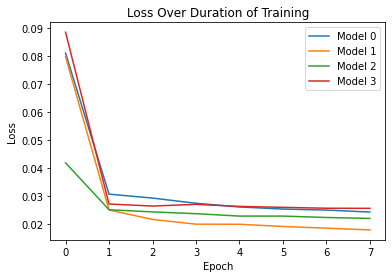

In [33]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model {i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

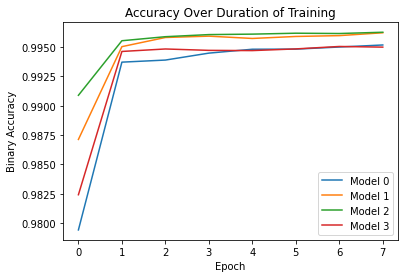

In [34]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model {i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [35]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4160/4160 [==============================] - 6s 1ms/step - loss: 0.0270 - binary_accuracy: 0.9926


In [36]:
networks = [models.Sequential() for i in range(4)]
histories = []

for net in networks:
    net.add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
    net.add(layers.Conv2D(6 + 2 * i, (3, 3), strides=1, activation='relu'))
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))
    net.add(layers.Conv2D(6 + 2 * i, (3, 3), strides=1, activation='relu'))
    net.add(layers.Flatten())
    net.add(layers.Dense(2, activation='sigmoid'))

In [37]:
for net in networks:    
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0419 - binary_accuracy: 0.9908
Epoch 2/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0260 - binary_accuracy: 0.9952
Epoch 3/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0236 - binary_accuracy: 0.9958
Epoch 4/8
8346/8346 [==============================] - 28s 3ms/step - loss: 0.0229 - binary_accuracy: 0.9960
Epoch 5/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0224 - binary_accuracy: 0.9961
Epoch 6/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0219 - binary_accuracy: 0.9962
Epoch 7/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0215 - binary_accuracy: 0.9962
Epoch 8/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0219 - binary_accuracy: 0.9963
Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0424 - binary_accuracy: 0.9907
Epoch 2/8
8346/8346

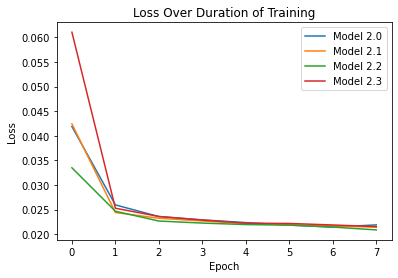

In [40]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model 2.{i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

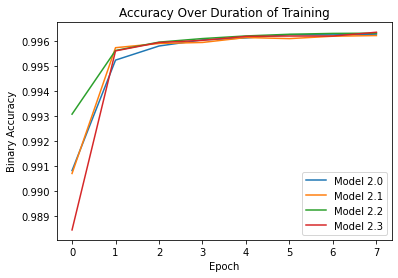

In [41]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model 2.{i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [42]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4160/4160 [==============================] - 7s 2ms/step - loss: 0.0207 - binary_accuracy: 0.9946


In [44]:
networks = [models.Sequential() for i in range(4)]
histories = []

networks[0] = models.Sequential()
networks[0].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[0].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[0].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.Flatten())
networks[0].add(layers.Dense(2, activation='sigmoid'))

networks[1] = models.Sequential()
networks[1].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[1].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[1].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Flatten())
networks[1].add(layers.Dense(2, activation='sigmoid'))

networks[2] = models.Sequential()
networks[2].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[2].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[2].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[2].add(layers.Flatten())
networks[2].add(layers.Dense(2, activation='sigmoid'))

networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(2, activation='sigmoid'))


In [45]:
histories = []
for net in networks:    
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0426 - binary_accuracy: 0.9896
Epoch 2/8
8346/8346 [==============================] - 28s 3ms/step - loss: 0.0248 - binary_accuracy: 0.9954
Epoch 3/8
8346/8346 [==============================] - 35s 4ms/step - loss: 0.0223 - binary_accuracy: 0.9957
Epoch 4/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0208 - binary_accuracy: 0.9959
Epoch 5/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0204 - binary_accuracy: 0.9958
Epoch 6/8
8346/8346 [==============================] - 34s 4ms/step - loss: 0.0197 - binary_accuracy: 0.9959
Epoch 7/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0200 - binary_accuracy: 0.9959
Epoch 8/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0195 - binary_accuracy: 0.9960
Epoch 1/8
8346/8346 [==============================] - 38s 4ms/step - loss: 0.0536 - binary_accuracy: 0.9890
Epoch 2/8
8346/8346

In [47]:
networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(2, activation='sigmoid'))

networks[3].compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
histories[3] = networks[3].fit(training_images, training_labels, epochs=8)

Epoch 1/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0541 - binary_accuracy: 0.9895
Epoch 2/8
8346/8346 [==============================] - 33s 4ms/step - loss: 0.0271 - binary_accuracy: 0.9952
Epoch 3/8
8346/8346 [==============================] - 31s 4ms/step - loss: 0.0270 - binary_accuracy: 0.9952
Epoch 4/8
8346/8346 [==============================] - 31s 4ms/step - loss: 0.0251 - binary_accuracy: 0.9956
Epoch 5/8
8346/8346 [==============================] - 29s 4ms/step - loss: 0.0240 - binary_accuracy: 0.9958
Epoch 6/8
8346/8346 [==============================] - 34s 4ms/step - loss: 0.0235 - binary_accuracy: 0.9958
Epoch 7/8
8346/8346 [==============================] - 33s 4ms/step - loss: 0.0234 - binary_accuracy: 0.9958
Epoch 8/8
8346/8346 [==============================] - 35s 4ms/step - loss: 0.0230 - binary_accuracy: 0.9959


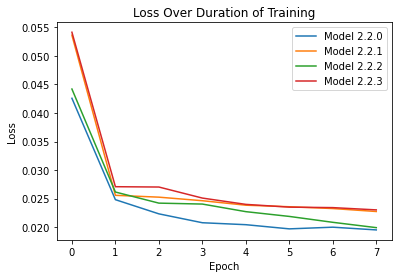

In [68]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model 2.2.{i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

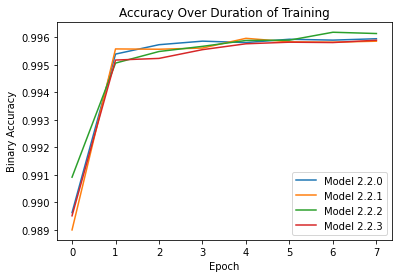

In [69]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model 2.2.{i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [50]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4160/4160 [==============================] - 6s 1ms/step - loss: 0.0326 - binary_accuracy: 0.9897


In [63]:
network = networks[0]
predictions = network.predict(training_images)

8346/8346 [==============================] - 11s 1ms/step


In [67]:
n_loops = 20
predictions = np.reshape(predictions, (100, predictions.shape[0] // 100, 2))

ValueError: cannot reshape array of size 534088 into shape (100,2670,2)

In [ ]:
print(testing_labels.shape)

(267044, 2)


# TODO
* Automate testing and training for different hyperparameters
* Make multiple models to compare against each other
* Try new gaussian fitting method
* Improve tweezer position finding algorithm
* Bright to dark and dark to bright splits
* Create fraction of dataset for testing data
* Change how crops are stored; make higher dimensional array with axes [tweezer, loop, image, crop_height, crop_width]
* Bright to dark and dark to bright probability